# 1. importing libs

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

In [2]:
# We will set the seed for reproducibility.
np.random.seed(1234)  
PYTHONHASHSEED = 0

# 2. Load the Dataset

In [3]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('/kaggle/input/predictivemaintenace-dataset/PM_train.txt/PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('/kaggle/input/predictivemaintenace-dataset/PM_test.txt/PM_test.txt', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


In [4]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [5]:
print(len(train_df))
print(len(test_df))

20631
13096


In [6]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [7]:
test_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916


In [8]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('/kaggle/input/predictivemaintenace-dataset/PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [9]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


# 3. Data Preprocessing

# 3.1 Generating classification target variable

In [10]:
# method and specify which columns are to be considered while sorting using the parameter.

train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

In [11]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [12]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

In [13]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

# 3.2 Normalize Training Dataset

In [14]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [15]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [16]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the 
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


# 4. Exploratory Data Analysis

<Axes: >

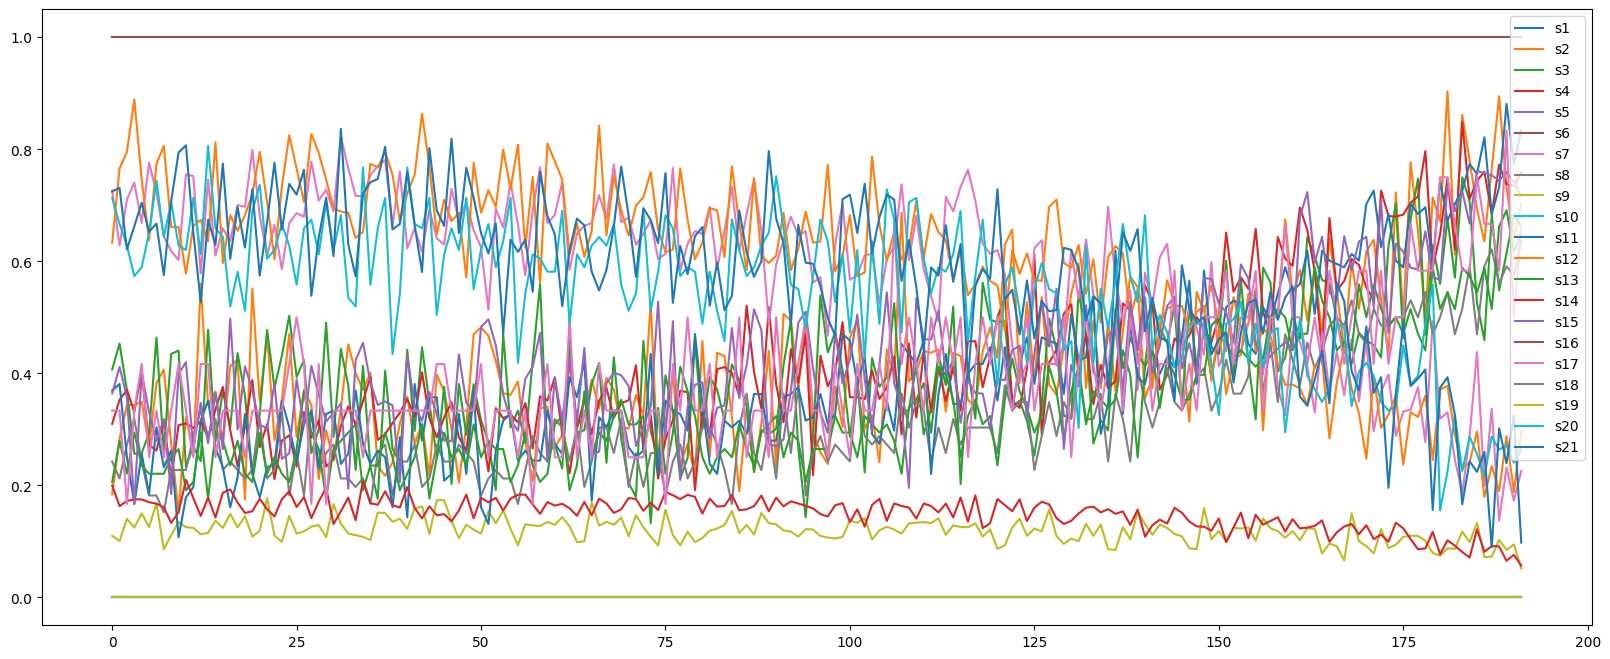

In [17]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

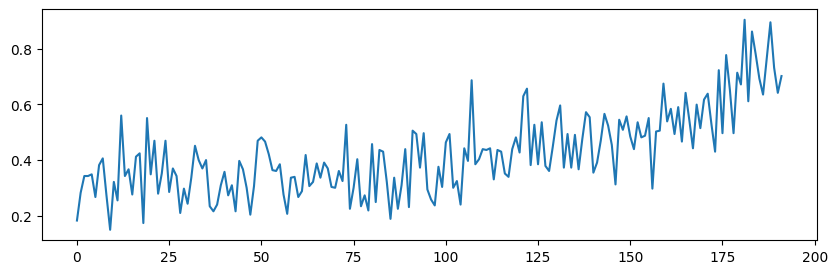

In [18]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

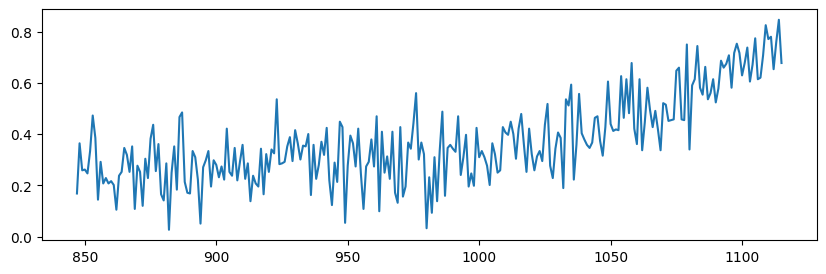

In [19]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

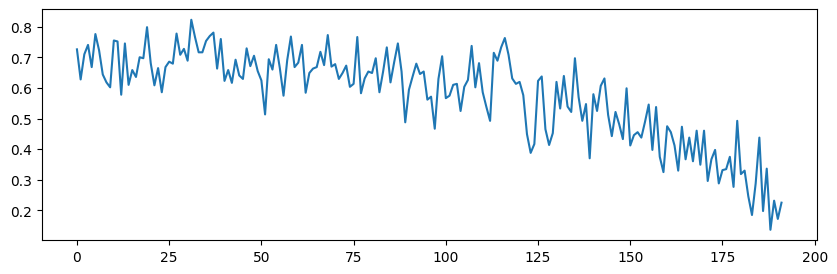

In [20]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

<Axes: >

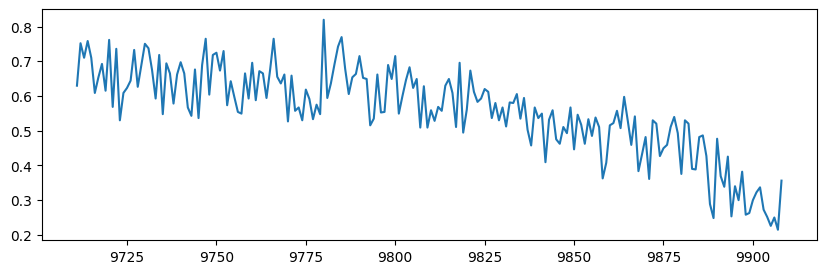

In [21]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

# 5. Generating Input Sequence

In [22]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

In [23]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [24]:
# Pick the feature columns. 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

In [25]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

In [26]:
def label_generator(label_df, seq_length, label):
    """
    Generates the labels for the sequences, starting from (seq_length+1)-th label.
    
    Arguments:
    label_df : DataFrame with the labels.
    seq_length : The length of the input sequences.
    label : The column name containing the labels to be used.
    
    Returns:
    label_array : A NumPy array of labels corresponding to the given sequence length.
    """
    
    # Extract the labels column as a numpy array
    label_array = label_df[label].values
    
    # Ensure label_array is a 2D array (in case it's a 1D array)
    if label_array.ndim == 1:
        label_array = label_array.reshape(-1, 1)
    
    # Number of elements in the label array
    num_elements = label_array.shape[0]
    
    # Slice the labels starting from seq_length to the end
    # This assumes that label_array is a 2D array (n_samples, 1)
    return label_array[seq_length:num_elements, :]


In [27]:
import numpy as np

# One-hot encoding function for multi-class classification
def one_hot_encode(label, num_classes=25):
    """Convert a scalar label to one-hot encoded vector."""
    return np.eye(num_classes)[label]  # Converts a scalar label to a one-hot vector of length 25

# Modify the label generation process
label_gen = [
    one_hot_encode(label_generator(train_df[train_df['id'] == id], sequence_length, ['failure_within_w1']), num_classes=25)
    for id in train_df['id'].unique()
]

# Concatenate all labels into a single array
label_set = np.concatenate(label_gen).astype(np.float32)

# Check the shape of the label set
print(label_set.shape)  # Should print (15631, 25)


(15631, 1, 25)


In [28]:
# Remove the extra dimension (squeeze to make it 2D)
label_set = np.concatenate(label_gen).astype(np.float32)

# Remove the second dimension of size 1 (if it exists)
label_set = label_set.squeeze(axis=1)

# Check the shape of the label set
print(label_set.shape)  # Should print (15631, 25)


(15631, 25)


# 6.1 build the model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Define the CNN-BiLSTM model with the correct input shape (50 timesteps, 25 features)
model = Sequential()

# Input layer with the correct input shape for 25 features
model.add(Input(shape=(50, 25)))  # 50 timesteps, 25 features per timestep

# Add a Conv1D layer to extract local features (use 64 filters and kernel size of 3)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add a MaxPooling1D layer to downsample the feature maps
model.add(MaxPooling1D(pool_size=2))

# Add a Bidirectional LSTM layer with 64 units, return_sequences=True for stacked LSTM
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Add another Bidirectional LSTM layer with 64 units
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))

# Dropout layer for regularization
model.add(Dropout(0.2))

# Dense layer with ReLU activation
model.add(Dense(32, activation='relu'))

# Another Dropout layer for regularization
model.add(Dropout(0.2))

# Output layer for multi-class classification
model.add(Dense(25, activation='softmax'))  # 25 units for 25 classes

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,681 (682.35 KB)

 Trainable params: 174,681 (682.35 KB)

 Non-trainable params: 0 (0.00 B)

# 6.2 train the model

In [30]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Number of epochs and batch size for training
epochs = 200
batch_size = 200

# Define the path to save the best model
model_path = 'best_cnn_bi_lstm_model.keras'

# Start tracking the training time
start = time.time()

# Train the CNN-BiLSTM model
cnn_bi_lstm_history = model.fit(
    seq_set_f25, label_set,  # seq_set is your input sequence data, label_set is your one-hot encoded labels
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.05,  # Use 5% of the data for validation
    verbose=2,
    callbacks=[
        EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='min'),  # Early stopping with min_delta and increased patience
        ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)  # Save the best model based on validation loss
    ]
)

# Track the end time of the training process
end = time.time()

# Print the total time taken for training
print("Total time taken for training: ", "{:.2f}".format((end - start)), " secs")


Epoch 1/200

Epoch 1: val_loss improved from inf to 0.29783, saving model to best_cnn_bi_lstm_model.keras
75/75 - 17s - 226ms/step - accuracy: 0.7668 - loss: 0.8158 - val_accuracy: 0.8785 - val_loss: 0.2978
Epoch 2/200

Epoch 2: val_loss improved from 0.29783 to 0.15323, saving model to best_cnn_bi_lstm_model.keras
75/75 - 9s - 121ms/step - accuracy: 0.9114 - loss: 0.2428 - val_accuracy: 0.9361 - val_loss: 0.1532
Epoch 3/200

Epoch 3: val_loss improved from 0.15323 to 0.08930, saving model to best_cnn_bi_lstm_model.keras
75/75 - 9s - 120ms/step - accuracy: 0.9429 - loss: 0.1532 - val_accuracy: 0.9680 - val_loss: 0.0893
Epoch 4/200

Epoch 4: val_loss improved from 0.08930 to 0.04913, saving model to best_cnn_bi_lstm_model.keras
75/75 - 9s - 121ms/step - accuracy: 0.9621 - loss: 0.0991 - val_accuracy: 0.9757 - val_loss: 0.0491
Epoch 5/200

Epoch 5: val_loss did not improve from 0.04913
75/75 - 10s - 128ms/step - accuracy: 0.9634 - loss: 0.0958 - val_accuracy: 0.9604 - val_loss: 0.1057
Ep

# 6.3 model evaluation on validation set

In [31]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(seq_set_f25, label_set, batch_size=batch_size, verbose=2)

# Print the evaluation results
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy*100:.2f}%")


79/79 - 4s - 47ms/step - accuracy: 0.9859 - loss: 0.0320
Validation Loss: 0.0320
Validation Accuracy: 98.59%


# plot training and validation metrics

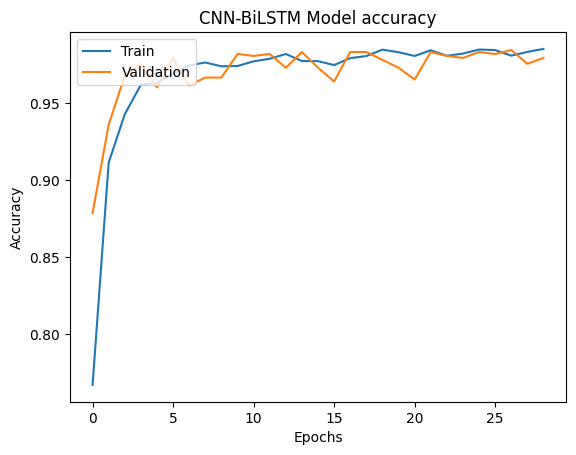

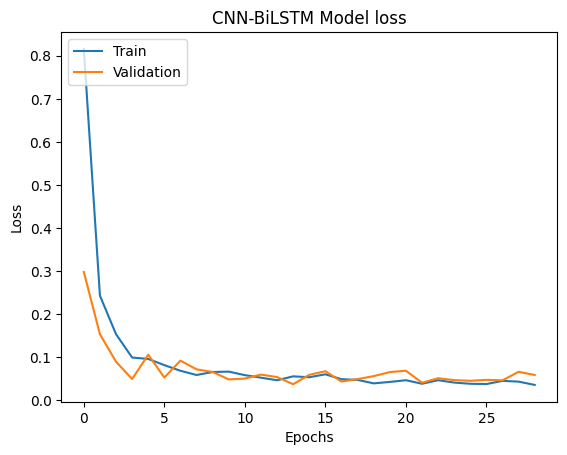

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(cnn_bi_lstm_history.history['accuracy'])
plt.plot(cnn_bi_lstm_history.history['val_accuracy'])
plt.title('CNN-BiLSTM Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn_bi_lstm_history.history['loss'])
plt.plot(cnn_bi_lstm_history.history['val_loss'])
plt.title('CNN-BiLSTM Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


save the model

In [33]:
# Save the model in Keras format (.keras)
model.save("model_best.keras")


In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# If the labels are one-hot encoded, convert them back to the original labels (use np.argmax())
y_true = np.argmax(label_set, axis=-1)  # Convert the one-hot encoded true labels to the original labels
y_pred = np.argmax(model.predict(seq_set_f25, verbose=1, batch_size=200), axis=-1)  # Get the predicted labels from the model

# For binary classification, you can use a threshold to get binary predictions (uncomment for binary classification)
# y_true = label_set.flatten()  # Flatten true labels for binary classification
# y_pred = (model.predict(seq_set_f25, verbose=1, batch_size=200) > 0.5).astype("int32").flatten()  # Thresholded predictions for binary classification

# Save the predictions to a CSV file for submission or analysis
test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index=None)

# Confusion matrix: Compares true vs predicted labels
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Compute precision and recall: Evaluates the quality of the classification
precision = precision_score(y_true, y_pred, average='macro')  # For multi-class classification, 'macro' is often used
recall = recall_score(y_true, y_pred, average='macro')  # Similarly, 'macro' is commonly used for multi-class
print('Train Precision = ', precision, '\n', 'Train Recall = ', recall)


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12380   151]
 [   69  3031]]
Train Precision =  0.9735014774800356 
 Train Recall =  0.9828459098854196


# model evaluation on test data set

Test sequence shape: (93, 50, 25)
One-hot encoded label shape: (93, 25)
Model loaded successfully.
3/3 - 1s - 434ms/step - accuracy: 0.9785 - loss: 0.0484
Total time taken for inferencing: 1.36 secs
Test Accuracy: 0.9785
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


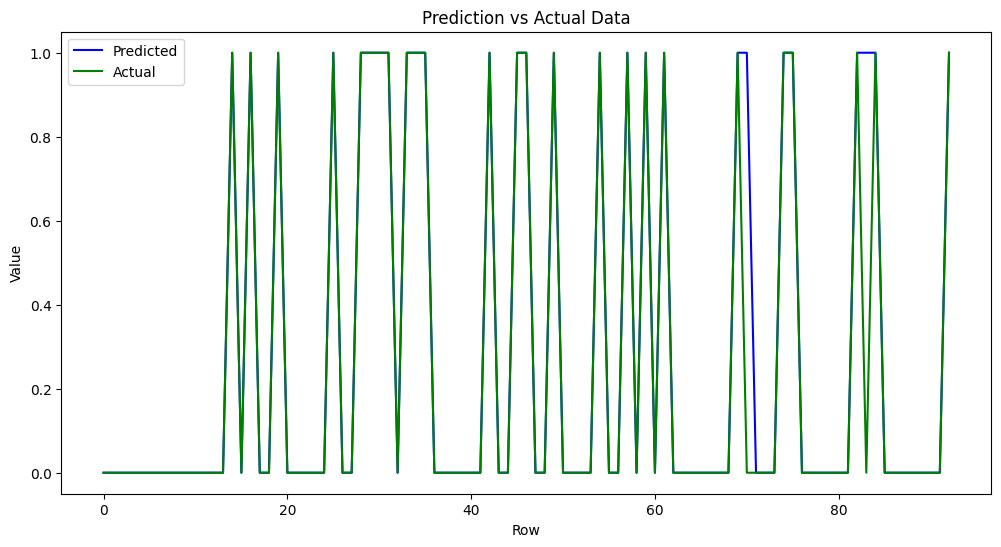

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 0 25]]
Test Precision = 0.9630
Test Recall = 0.9853


In [35]:
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Assuming the model path is 'best_cnn_bi_lstm_model.keras' (Change this if your model path differs)
model_path = 'best_cnn_bi_lstm_model.keras'

# Extract the last sequence of each engine in the test set
last_test_seq = [test_df[test_df['id'] == id][sequence_cols_25].values[-sequence_length:] 
                 for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get the labels of the test set (last row of the test data for each engine)
y_mask = [len(test_df[test_df['id'] == id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0], 1).astype(np.float32)

# One-hot encode the labels (assuming 25 classes for multi-class classification)
last_test_label = to_categorical(last_test_label, num_classes=25)

# Check the shape of sequences and labels
print(f"Test sequence shape: {last_test_seq.shape}")
print(f"One-hot encoded label shape: {last_test_label.shape}")

# Clear any existing session to avoid variable re-creation issues
tf.keras.backend.clear_session()

# Load the pre-trained model
if os.path.isfile(model_path):
    estimator = load_model(model_path)
    print("Model loaded successfully.")
else:
    print("Model not found at path:", model_path)

# Evaluate the model on the test set
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print(f"Total time taken for inferencing: {end - start:.2f} secs")

# Print test accuracy
print(f"Test Accuracy: {scores_test[1]:.4f}")

# Generate predictions
predictions = estimator.predict(last_test_seq)
predicted_labels = np.argmax(predictions, axis=1)  # Convert from one-hot to categorical labels
actual_labels = np.argmax(last_test_label, axis=1)  # Convert from one-hot to categorical labels

# Plot predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(predicted_labels, color='blue', label='Predicted')
plt.plot(actual_labels, color='green', label='Actual')
plt.title("Prediction vs Actual Data")
plt.xlabel("Row")
plt.ylabel("Value")
plt.legend()
plt.show()

# Save predictions to a CSV file
test_set = pd.DataFrame(predicted_labels)
test_set.to_csv('binary_submit_test.csv', index=None)

# Confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(actual_labels, predicted_labels)
print(cm)

# Compute precision and recall
precision = precision_score(actual_labels, predicted_labels, average='macro')  # For multi-class
recall = recall_score(actual_labels, predicted_labels, average='macro')  # For multi-class
print(f'Test Precision = {precision:.4f}\nTest Recall = {recall:.4f}')


In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming last_test_seq is your test data and last_test_label is the true one-hot encoded labels
# Convert one-hot encoded labels to single integer labels for evaluation
true_labels = np.argmax(last_test_label, axis=1)

# Get the predictions from the model and convert them to single integer labels
predictions = estimator.predict(last_test_seq)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1-score for multi-class classification (using macro average)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Test Precision (Macro): {precision}")
print(f"Test Recall (Macro): {recall}")
print(f"Test F1-score (Macro): {f1}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Confusion matrix:
[[66  2]
 [ 0 25]]
Test Precision (Macro): 0.962962962962963
Test Recall (Macro): 0.9852941176470589
Test F1-score (Macro): 0.9733065442020665
